### Importing The Libraries

In [2]:

# For Ignoring the warning
import warnings
warnings.filterwarnings("ignore")

# Importing for data Defination
import pandas as pd
import numpy as np

# Importing libraries for visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for Time series analysis
from datetime import datetime, timedelta
import statsmodels.api as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing Libraries for Machine Learning
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor

### Reading the Data into a Dataframe

In [3]:

# Reading the csv file into the dataframe
df = pd.read_csv('daily-website-visitors.csv')

In [4]:

# Viewing the records of the dataframe
df.head(10)

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236
5,6,Friday,6,9/19/2014,"2,815","1,863","1,622",241
6,7,Saturday,7,9/20/2014,"1,658","1,118",985,133
7,8,Sunday,1,9/21/2014,"2,288","1,656","1,481",175
8,9,Monday,2,9/22/2014,"3,638","2,586","2,312",274
9,10,Tuesday,3,9/23/2014,"4,462","3,257","2,989",268


In [5]:

# We will be retaining the original dataframe adn will be working on the copy of it
df1 = df.copy()

In [6]:

# Converting the Datatype of the Date Column to Date time
df1['Date'] = pd.to_datetime(df['Date'])

In [7]:

# Setting the Date column as the index of the Dataframe as we are going to perform the time series analysis 
df1.set_index('Date', inplace = True)

In [8]:

# Dropping the unwanted column from the dataframe as we are performing time series analysis
df1.drop(['Row', 'Day.Of.Week'], axis = 1, inplace = True)

In [9]:

# As we can see that all the columns in the dataframe are object and we want it to be numeric but as we can see the 
# data we saw that the reason that is is being showing object is because of the presence of ',' so we have 
# to first remove the ',' and then convert the columns to numeric

df1['Page.Loads'] = df1['Page.Loads'].str.replace(',', '')
df1['Unique.Visits'] = df1['Unique.Visits'].str.replace(',', '')
df1['First.Time.Visits'] = df1['First.Time.Visits'].str.replace(',', '')
df1['Returning.Visits'] = df1['Returning.Visits'].str.replace(',', '')

# Converting the Page.Loads, Unique.Visits, First.Time.Visits, Returning.Visits to numeric

df1['Page.Loads'] = pd.to_numeric(df1['Page.Loads'])
df1['Unique.Visits'] = pd.to_numeric(df1['Unique.Visits'])
df1['First.Time.Visits'] = pd.to_numeric(df1['First.Time.Visits'])
df1['Returning.Visits'] = pd.to_numeric(df1['Returning.Visits'])

In [10]:

# Dropping the columns so that we just focus on the target variable
df1.drop(['Unique.Visits', 'First.Time.Visits', 'Returning.Visits'], axis = 1, inplace = True)

### Creating the functions that will be required

> __Function for Histogram and Boxplot__

In [11]:

# Functions for histogram and box plots

def viz_box_hist(dataframe, x_value):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot the histogram on the first axis (axes[0])
    sns.histplot(data = dataframe, x = x_value, ax = axes[0], kde = True)
    axes[0].set_title(str(x_value) + ' Distribution (Histogram)')
    
    # Plot the box plot on the second axis (axes[1])
    sns.boxplot(data = dataframe, x = x_value, ax = axes[1])
    axes[1].set_title(str(x_value) + ' Distribution (Boxplot)')

> __Function For a normal Plot__

In [12]:

# Function for Plotting the Normal Plot

def viz_normal_plot(dataframe, value):
    dataframe[value].plot(figsize = (12, 6))
    plt.show()

> __Function for Dickey-fuller Test__

In [13]:

# Function for Dickey-Fuller Test for identifying if the data is stationary or not
# Here series means the column name of the dataframe on which you want to apply the Dickey-Fuller Test

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('P-value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis, indicating *Data is Stationary*.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating Data is *Not Stationary*.")

> __Function for ACF and PACF Plots__

In [14]:
# Function for acf and pacf graphs

def acf_pacf_plot(dataframe, value):
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the ACF graph on the first axis
    plot_acf(dataframe[value].dropna(), ax=axes[0])
    axes[0].set_title('ACF Plot')
    
    # Plot the PACF graph on the second axis
    plot_pacf(dataframe[value].dropna(), ax=axes[1])
    axes[1].set_title('PACF Plot')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


> __Function for SARIMAX Model__

In [15]:
def sarima_model(train_data, test_data, column, order, seasonal_order, pred_start_date, pred_end_date):
    """
    Function to fit a SARIMA model, make predictions, and plot results.
    
    Parameters:
    train_data (DataFrame): The training data containing time series.
    test_data (DataFrame): The test data containing time series.
    column (str): The name of the column to model.
    order (tuple): The ARIMA order (p, d, q).
    seasonal_order (tuple): The seasonal order (P, D, Q, S).
    pred_start_date (str): The start date for predictions.
    pred_end_date (str): The end date for predictions.
    
    Returns:
    model_fit (SARIMAXResults): Fitted SARIMA model.
    
    """
    
    # Fit SARIMA model
    sarima_model = SARIMAX(train_data[column], 
                           order=order, 
                           seasonal_order=seasonal_order, 
                           enforce_stationarity=False, 
                           enforce_invertibility=False)
    
    model_fit = sarima_model.fit()

    # Print model summary
    print(model_fit.summary())
    
    # Predict on test data
    pred_values = model_fit.predict(start=pred_start_date, end=pred_end_date)
    
    # Calculate residuals
    residuals = test_data[column] - pred_values
    
    # Print residuals
    print(f"Residuals:\n{residuals}")
    
    # Plot residuals
    model_fit.resid.plot(kind='kde')
    plt.title('Residuals Distribution')
    plt.show()
    
    # Add predicted values to test_data
    test_data['Predicted_SARIMA'] = pred_values
    
    # Plot actual vs predicted
    test_data[[column, 'Predicted_SARIMA']].plot(figsize=(12, 6))
    plt.title('Actual vs Predicted')
    plt.show()
    
    # Print AIC and BIC
    print(f'AIC: {model_fit.aic}, BIC: {model_fit.bic}')
    
    return model_fit

> __Function for SARIMAX Forecasting__

In [16]:

def sarima_forecast(data, column, order, seasonal_order, forecast_steps):
    """
    Function to fit a SARIMA model on the entire dataset and forecast future values.

    Parameters:
    data (DataFrame): The dataset containing the time series data.
    column (str): The column name to be modeled.
    order (tuple): The ARIMA order (p, d, q).
    seasonal_order (tuple): The seasonal order (P, D, Q, S).
    forecast_steps (int): The number of steps (time periods) to forecast into the future.

    Returns:
    prediction (Series): The forecasted values.
    """
    
    # Fit SARIMA model on entire data
    sarima_model = SARIMAX(data[column], order=order, seasonal_order=seasonal_order).fit()
    
    # Generate future predictions
    prediction = sarima_model.predict(len(data), len(data) + forecast_steps - 1)
    
    # Plot actual data and predictions
    data[column].plot(legend=True, label='Train', figsize=(12, 6))
    prediction.plot(legend=True, label='Prediction')
    plt.title('SARIMA Model - Actual vs Forecast')
    plt.show()
    
    return prediction


> __We will be creating a Dataset which we will aggregate to weekly data__

In [17]:
df1_weekly = df1.copy()

In [18]:

# Converting into weekly data 
df1_weekly = df1_weekly['Page.Loads'].resample(rule= 'W').sum()

In [19]:

# Converting into a dataframe
df1_weekly = pd.DataFrame(df1_weekly)

In [20]:

# Viewing the records
df1_weekly.head()

,Page.Loads
Date,
2014-09-14,2146
2014-09-21,21063
2014-09-28,24273
2014-10-05,24114
2014-10-12,26310


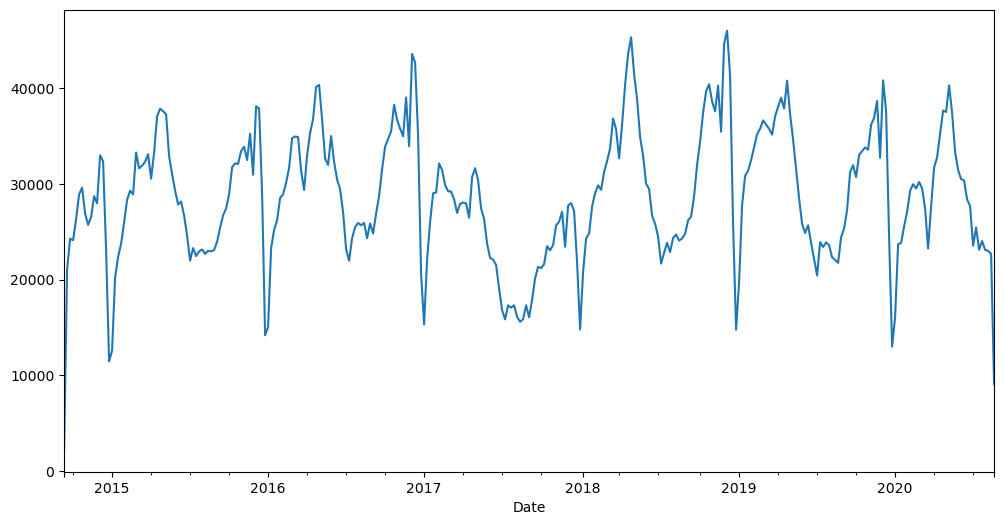

In [21]:

# Plotting the graph of the Weekly data to see how it actually looks
viz_normal_plot(df1_weekly, 'Page.Loads')

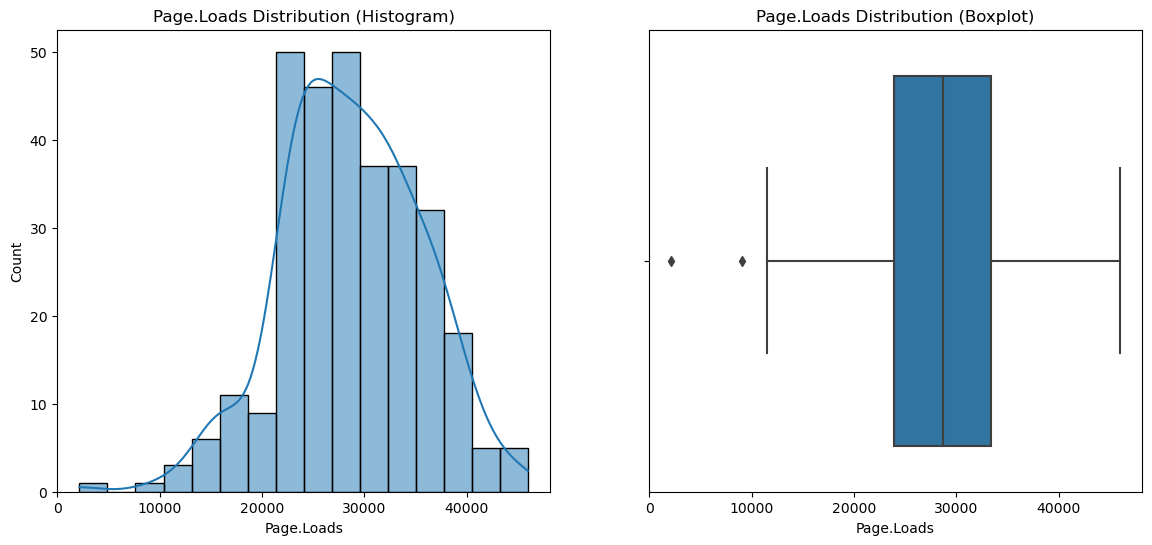

In [22]:

# Chekcing for the distribution of the Page.Loads
viz_box_hist(df1_weekly, 'Page.Loads')

> __By Seeing at the graph we can come to a conclusion that there are some outliers in the data that and we will remove them as it will cause unessacary noise in the data and can also disrupt the trend in the data.__

In [23]:

#Setting the IQR Range and evaluating
Q1 = df1_weekly['Page.Loads'].quantile(0.25)
Q3 = df1_weekly['Page.Loads'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_data = df1_weekly[(df1_weekly['Page.Loads'] >= lower_bound) & (df1_weekly['Page.Loads'] <= upper_bound)]

In [24]:
df1_weekly = filtered_data

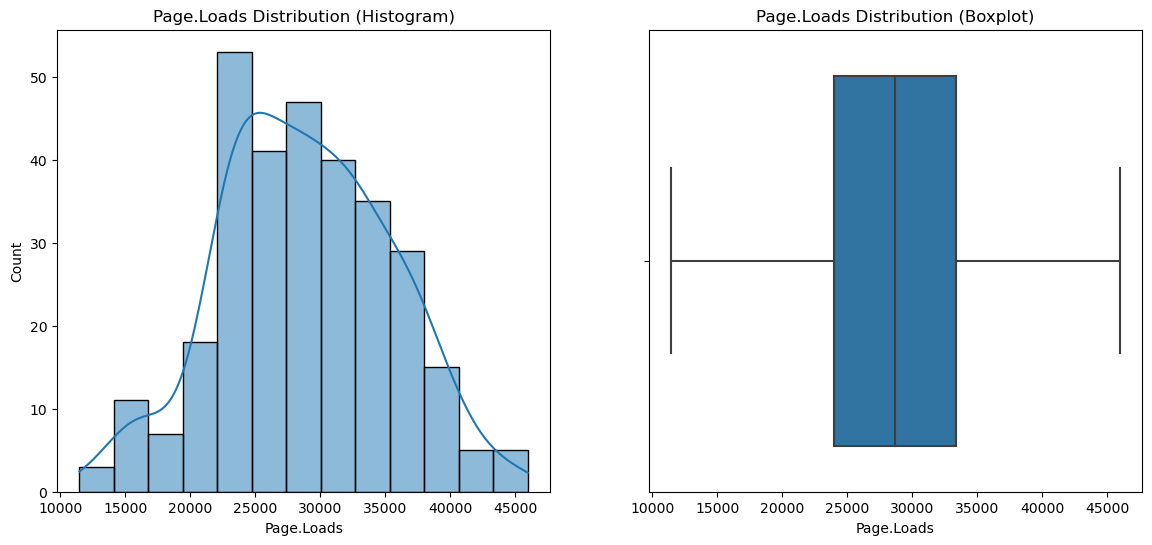

In [25]:

# Again viewing the distribution of the data after removing the outliers
viz_box_hist(df1_weekly, 'Page.Loads')

In [26]:

# Checking for null values in the weekly Data
df1_weekly.isnull().sum()

Page.Loads    0
dtype: int64

In [27]:

# Viewing the Statstical information of the datfarame
df1_weekly.describe()

,Page.Loads
count,309.000000
mean,28835.822006
std,6616.048788
min,11466.000000
25%,23952.000000
50%,28705.000000
75%,33406.000000
max,45969.000000


> __As we have seen that the data is free of outliers and null values we will be checking that if the data is Stationary of not as we are implementing the Time series anlaysis ( TSA ) and for TSA the data must be Stationary.__

### To check if the data is staionary of not we will performing the Augmented Dickey-Fuller Test 

In [28]:
adf_test(df1_weekly['Page.Loads'])

ADF Statistics: -5.268713312106544
P-value: 6.3547585168425636e-06
Strong evidence against the null hypothesis, reject the null hypothesis, indicating *Data is Stationary*.


### To check if the Data is having any Sesonality present in it.

> __As we can see at the plot of the data that as time goes the data is not increaing in the upward manner so in conclusion we weill be applying the Additive model on the dataframe__

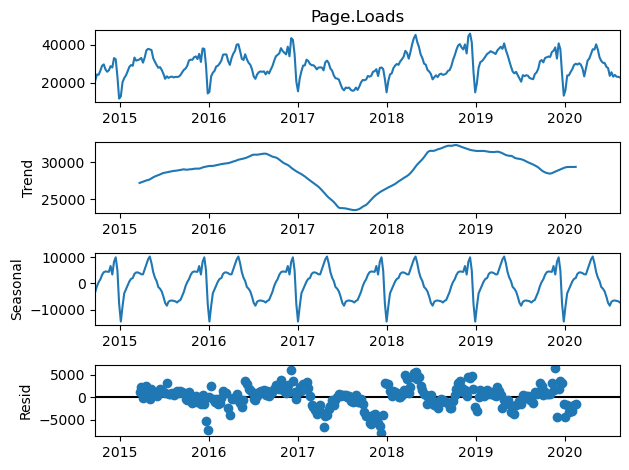

In [29]:

# Seeing if the data is having seasonality present in it
decomposition = sms.tsa.seasonal_decompose(df1_weekly['Page.Loads'], model = 'additive')
fig = decomposition.plot()
plt.show()

### By Seeing the Above graph we can see the following : 
> __The trend in the graph is increasing from 2015 and its dipping down at the mid of 2017 and again increasing fro that moment to 2020 and so so we can conclude that the data is overall stationary.__

> __By looking at the Seasonal graph we can see that the data is having a Yearly seasonal component and its reapeating anually.__

> __By Looking at the Resid Graph we can see that the residuals as almost at the 0 i.e almost all the data points has been covered.__

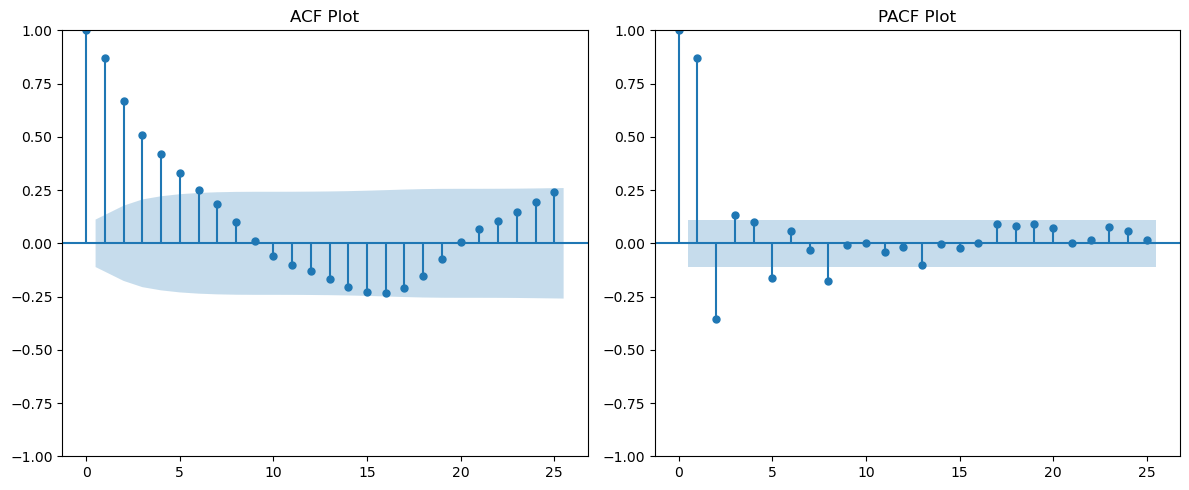

In [30]:

# Viewing the ACF and the PACF Graphs of the Data frame
acf_pacf_plot(df1_weekly, 'Page.Loads')

### From the Above ACF and PACF Graphs we can say that : 
> __The ACF graph is moving gradually indicating that there is a seasonality present in it.__

> __In PACF Graph we can see that there is sudden drop down after lag 1 and lag 2 , so overall we can say that the significants lags are 1, 2 and 3__

### As we know that there is Seasonality present in the data we will be implementing the SARIMAX Algo
> __So in this step we will be implementing the Sarimax Model on the data frame and for that we will be splitting the data into train and test data and we will be evaluating multiple model to check which ine is the best.__

> __We will be doing so by checking the AIC and BIC values of the model.__

In [31]:

# Initializing the end dates of train and test dataset
train_dataset_end_date = datetime(2018, 1, 1)
test_dataset_end_date = datetime(2020, 8, 1)

In [32]:

# Setting the train and the test data
train_data_weekly = df1_weekly[:train_dataset_end_date]
test_data_weekly = df1_weekly[train_dataset_end_date+ timedelta(days = 1):test_dataset_end_date]

In [33]:

# Viewing the Train Dataset
train_data_weekly.head(), train_data_weekly.tail()

(            Page.Loads
 Date                  
 2014-09-21       21063
 2014-09-28       24273
 2014-10-05       24114
 2014-10-12       26310
 2014-10-19       28903,
             Page.Loads
 Date                  
 2017-12-03       27723
 2017-12-10       27982
 2017-12-17       27166
 2017-12-24       21769
 2017-12-31       14798)

In [34]:

# Viewing the Test Dataset
test_data_weekly.head(), test_data_weekly.tail()

(            Page.Loads
 Date                  
 2018-01-07       20799
 2018-01-14       24283
 2018-01-21       24837
 2018-01-28       27630
 2018-02-04       29015,
             Page.Loads
 Date                  
 2020-06-28       27663
 2020-07-05       23535
 2020-07-12       25438
 2020-07-19       23116
 2020-07-26       24025)

In [35]:

# Initialzing the predictions start date and end date
pred_start_date = test_data_weekly.index[0]
pred_end_date = test_data_weekly.index[-1]

In [36]:

# Printing the Start and the end date of the Data
print(pred_start_date)
print(pred_end_date)

2018-01-07 00:00:00
2020-07-26 00:00:00


### By looking at the ACF adn PACF graph we will be implementing few model that include : 
> __(2, 0, 0)(1, 1, 0, 52)  --> Model 1__

> __(3, 0, 0)(1, 1, 0, 52)  --> Model 2__

> __(3, 0, 0)(1, 1, 0, 52)  --> Model 3__

## Model 1

                                     SARIMAX Results                                      
Dep. Variable:                         Page.Loads   No. Observations:                  172
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 52)   Log Likelihood                -605.991
Date:                            Tue, 01 Oct 2024   AIC                           1219.982
Time:                                    11:04:29   BIC                           1228.740
Sample:                                09-21-2014   HQIC                          1223.443
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0402      0.097     10.702      0.000       0.850       1.231
ar.L2         -0.1019      0.074   

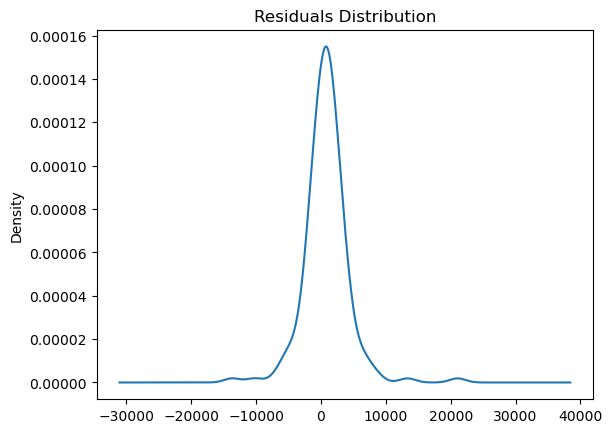

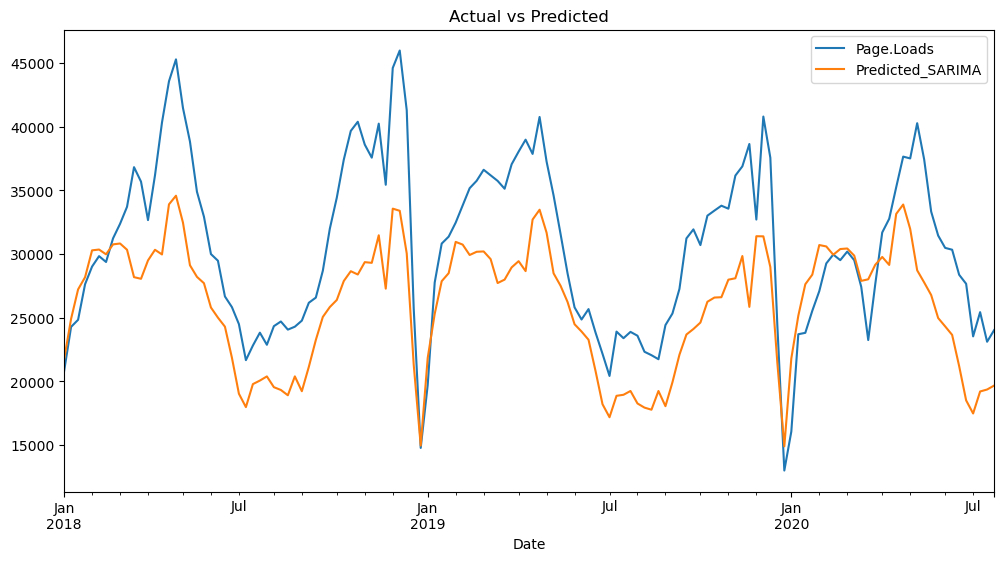

AIC: 1219.9818064731382, BIC: 1228.740425441244


In [37]:
sarima_model(train_data_weekly, test_data_weekly, 'Page.Loads', 
             order=(2, 0, 0), seasonal_order=(1, 1, 0, 52), 
             pred_start_date = pred_start_date, pred_end_date = pred_end_date)

## Forecasting of Model 1 for the next 5 Years

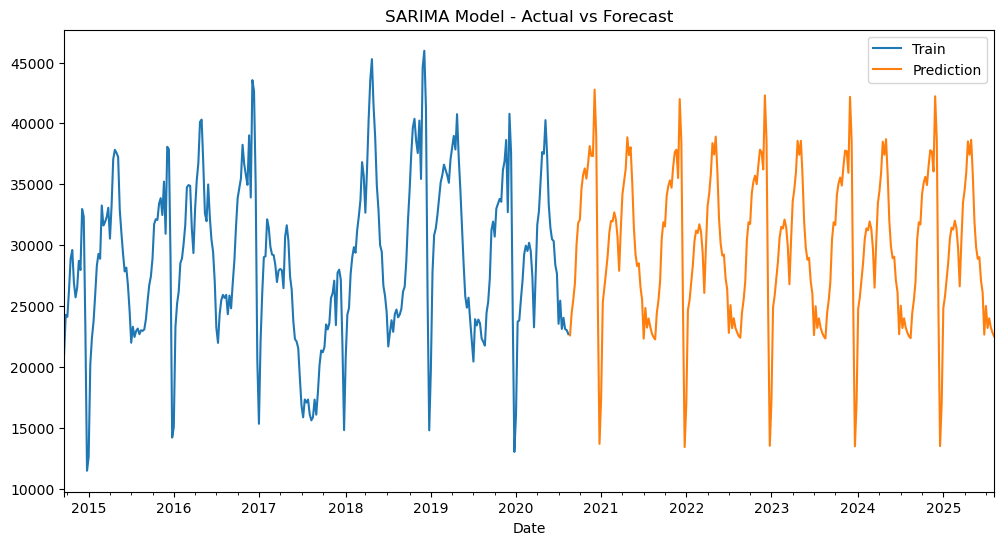

2020-08-23    22590.607882
2020-08-30    24417.952478
2020-09-06    25531.957802
2020-09-13    26872.669022
2020-09-20    30119.228792
                  ...     
2025-07-13    23193.113217
2025-07-20    23984.630957
2025-07-27    23238.278769
2025-08-03    22812.905611
2025-08-10    22503.672816
Freq: W-SUN, Name: predicted_mean, Length: 260, dtype: float64

In [38]:
sarima_forecast(df1_weekly, 'Page.Loads', order = (2, 0, 0), seasonal_order=(1, 1, 0, 52), forecast_steps = 260)

## Model 2

                                     SARIMAX Results                                      
Dep. Variable:                         Page.Loads   No. Observations:                  172
Model:             SARIMAX(3, 0, 0)x(1, 1, 0, 52)   Log Likelihood                -595.529
Date:                            Tue, 01 Oct 2024   AIC                           1201.058
Time:                                    11:05:12   BIC                           1211.930
Sample:                                09-21-2014   HQIC                          1205.348
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0807      0.119      9.084      0.000       0.848       1.314
ar.L2         -0.3885      0.204   

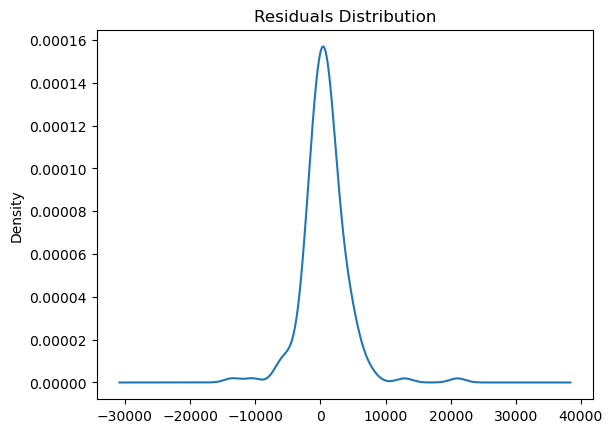

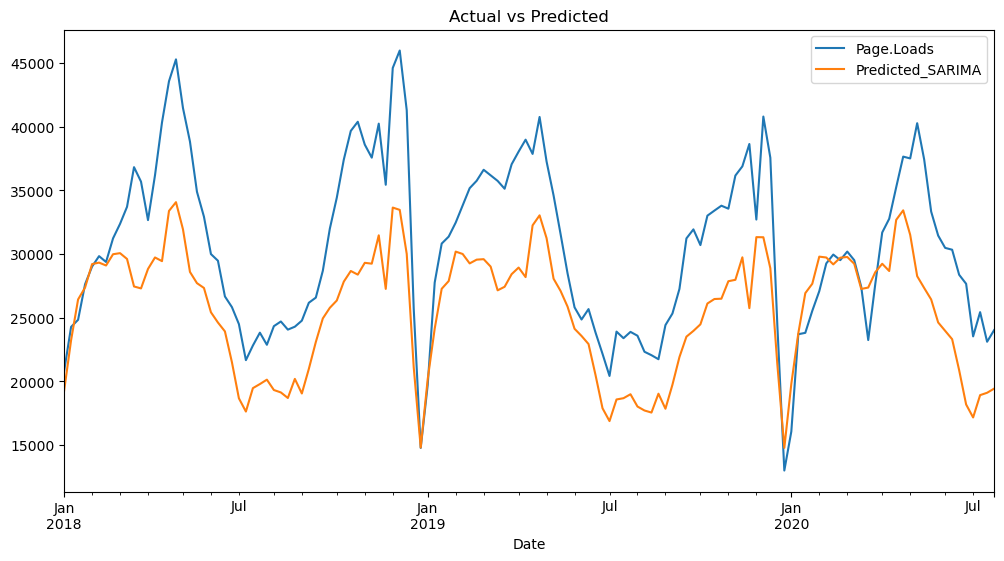

AIC: 1201.0583504561291, BIC: 1211.9302868056072


In [39]:
sarima_model(train_data_weekly, test_data_weekly, 'Page.Loads', 
             order=(3, 0, 0), seasonal_order=(1, 1, 0, 52), 
             pred_start_date = pred_start_date, pred_end_date = pred_end_date)

## Forecasting of Model 2 for the next 5 Years

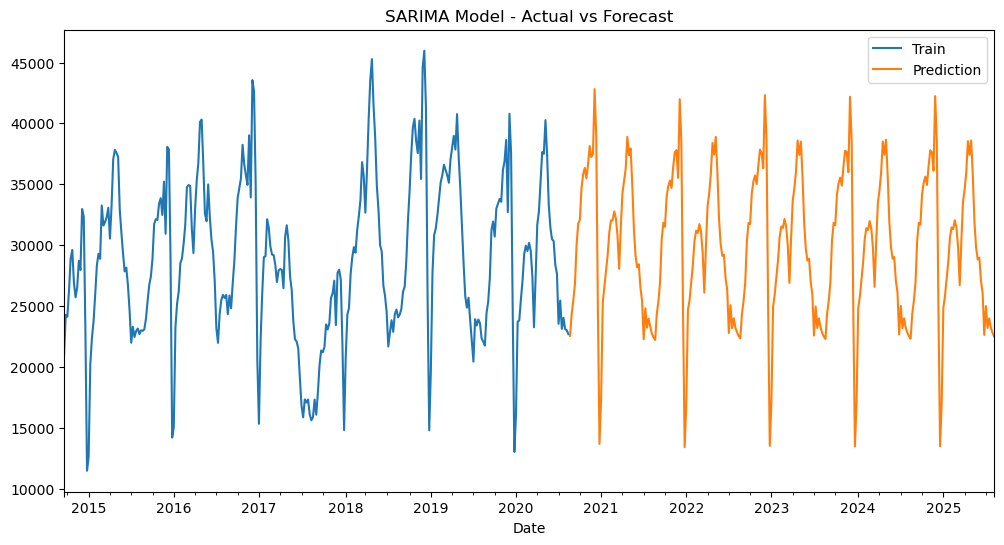

2020-08-23    22540.015557
2020-08-30    24330.646847
2020-09-06    25464.993910
2020-09-13    26786.465298
2020-09-20    30006.881455
                  ...     
2025-07-13    23191.092764
2025-07-20    23979.357021
2025-07-27    23238.545040
2025-08-03    22803.511684
2025-08-10    22494.971834
Freq: W-SUN, Name: predicted_mean, Length: 260, dtype: float64

In [40]:
sarima_forecast(df1_weekly, 'Page.Loads', order = (3, 0, 0), seasonal_order=(1, 1, 0, 52), forecast_steps = 260)

## Model 3

                                      SARIMAX Results                                      
Dep. Variable:                          Page.Loads   No. Observations:                  172
Model:             SARIMAX(3, 0, 3)x(1, 1, [], 52)   Log Likelihood                -591.443
Date:                             Tue, 01 Oct 2024   AIC                           1198.887
Time:                                     11:07:12   BIC                           1216.282
Sample:                                 09-21-2014   HQIC                          1205.750
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4654      0.457      1.018      0.308      -0.430       1.361
ar.L2          0.2699      

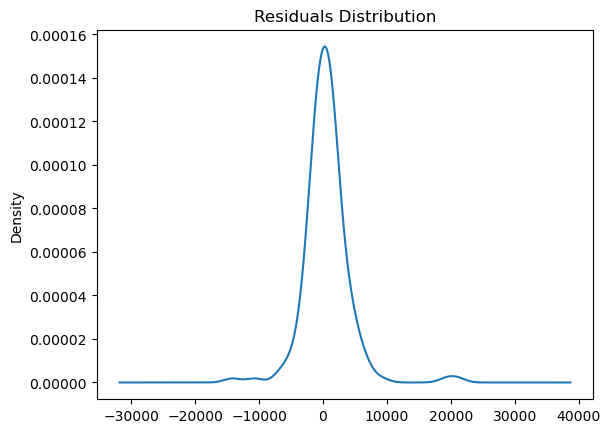

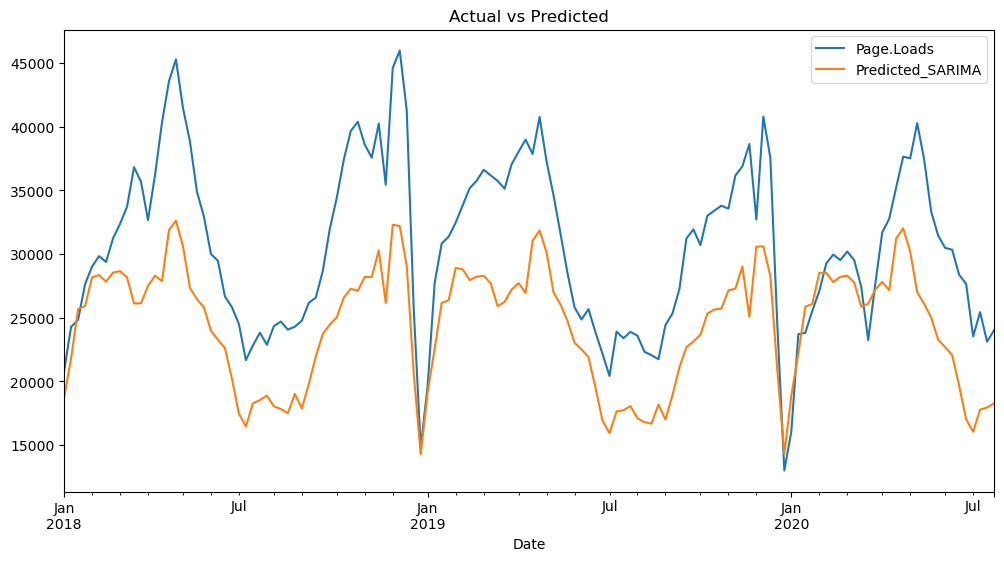

AIC: 1198.8868993641515, BIC: 1216.2819975233167


In [41]:
sarima_model(train_data_weekly, test_data_weekly, 'Page.Loads', 
             order=(3, 0, 3), seasonal_order=(1, 1, 0, 52), 
             pred_start_date = pred_start_date, pred_end_date = pred_end_date)

## Forecasting of Model 3 for the next 5 years

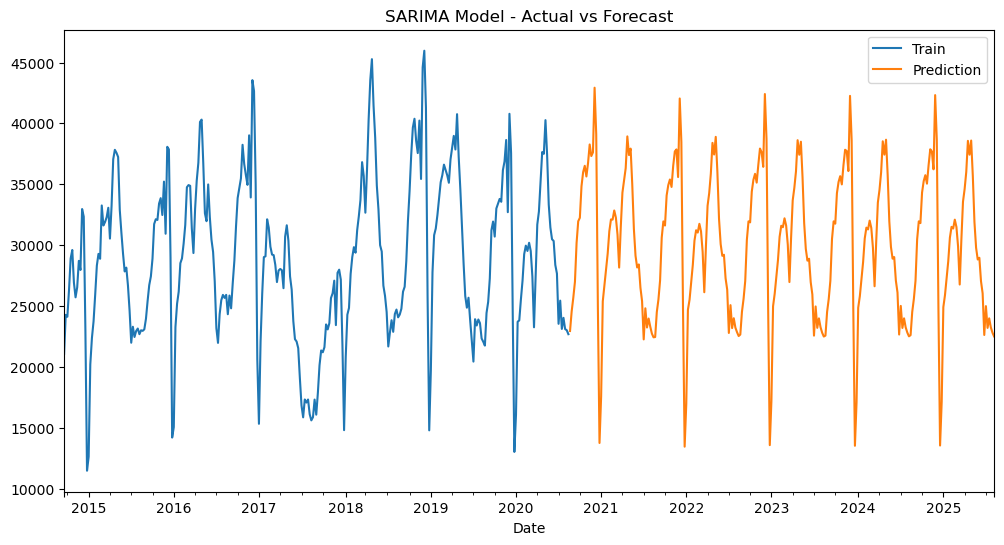

2020-08-23    22943.108091
2020-08-30    24553.070404
2020-09-06    25684.034058
2020-09-13    26986.127098
2020-09-20    30180.416107
                  ...     
2025-07-13    23198.988745
2025-07-20    23985.490551
2025-07-27    23246.180743
2025-08-03    22807.105961
2025-08-10    22498.356887
Freq: W-SUN, Name: predicted_mean, Length: 260, dtype: float64

In [42]:
sarima_forecast(df1_weekly, 'Page.Loads', order = (3, 0, 3), seasonal_order=(1, 1, 0, 52), forecast_steps = 260)

## Machine Learning Alogorithms

In [231]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [232]:

# We will be retaining the original dataframe adn will be working on the copy of it
df2 = df.copy()

In [233]:

# Converting the Datatype of the Date Column to Date time
df2['Date'] = pd.to_datetime(df['Date'])

In [234]:

# Setting the Date column as the index of the Dataframe as we are going to perform the time series analysis 
df2.set_index('Date', inplace = True)

In [235]:

# Dropping the unwanted column from the dataframe as we are performing time series analysis
df2.drop(['Row'], axis = 1, inplace = True)

In [236]:

# As we can see that all the columns in the dataframe are object and we want it to be numeric but as we can see the 
# data we saw that the reason that is is being showing object is because of the presence of ',' so we have 
# to first remove the ',' and then convert the columns to numeric

df2['Page.Loads'] = df2['Page.Loads'].str.replace(',', '')
df2['Unique.Visits'] = df2['Unique.Visits'].str.replace(',', '')
df2['First.Time.Visits'] = df2['First.Time.Visits'].str.replace(',', '')
df2['Returning.Visits'] = df2['Returning.Visits'].str.replace(',', '')

# Converting the Page.Loads, Unique.Visits, First.Time.Visits, Returning.Visits to numeric

df2['Page.Loads'] = pd.to_numeric(df2['Page.Loads'])
df2['Unique.Visits'] = pd.to_numeric(df2['Unique.Visits'])
df2['First.Time.Visits'] = pd.to_numeric(df2['First.Time.Visits'])
df2['Returning.Visits'] = pd.to_numeric(df2['Returning.Visits'])

In [237]:
df2.head(10)

,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,
2014-09-14,Sunday,1,2146,1582,1430,152
2014-09-15,Monday,2,3621,2528,2297,231
2014-09-16,Tuesday,3,3698,2630,2352,278
2014-09-17,Wednesday,4,3667,2614,2327,287
2014-09-18,Thursday,5,3316,2366,2130,236
2014-09-19,Friday,6,2815,1863,1622,241
2014-09-20,Saturday,7,1658,1118,985,133
2014-09-21,Sunday,1,2288,1656,1481,175
2014-09-22,Monday,2,3638,2586,2312,274


In [238]:

# Droppoing the Day columns
df2.drop(['Day'], axis = 1, inplace = True)


> __Here we are dropping the Day column as we can see what day represents what day__

In [239]:
df2.head()

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,
2014-09-14,1,2146,1582,1430,152
2014-09-15,2,3621,2528,2297,231
2014-09-16,3,3698,2630,2352,278
2014-09-17,4,3667,2614,2327,287
2014-09-18,5,3316,2366,2130,236


In [240]:
df2['Month'] = df2.index.month
df2['Year'] = df2.index.year
#df2['Dayofyear'] = df2.index.dayofyear

> __Creating the features such as Month and Year__

In [241]:
df2.head(10)

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year
Date,,,,,,,
2014-09-14,1,2146,1582,1430,152,9,2014
2014-09-15,2,3621,2528,2297,231,9,2014
2014-09-16,3,3698,2630,2352,278,9,2014
2014-09-17,4,3667,2614,2327,287,9,2014
2014-09-18,5,3316,2366,2130,236,9,2014
2014-09-19,6,2815,1863,1622,241,9,2014
2014-09-20,7,1658,1118,985,133,9,2014
2014-09-21,1,2288,1656,1481,175,9,2014
2014-09-22,2,3638,2586,2312,274,9,2014


In [242]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Day.Of.Week,2167.0,3.997231,2.000229,1.0,2.0,4.0,6.0,7.0
Page.Loads,2167.0,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
Unique.Visits,2167.0,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
First.Time.Visits,2167.0,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0
Returning.Visits,2167.0,511.822335,168.736370,133.0,388.5,509.0,626.5,1036.0
Month,2167.0,6.498846,3.462485,1.0,3.5,6.0,10.0,12.0
Year,2167.0,2017.169820,1.753180,2014.0,2016.0,2017.0,2019.0,2020.0


> __Viewing the plots for the monthly Page Loads__

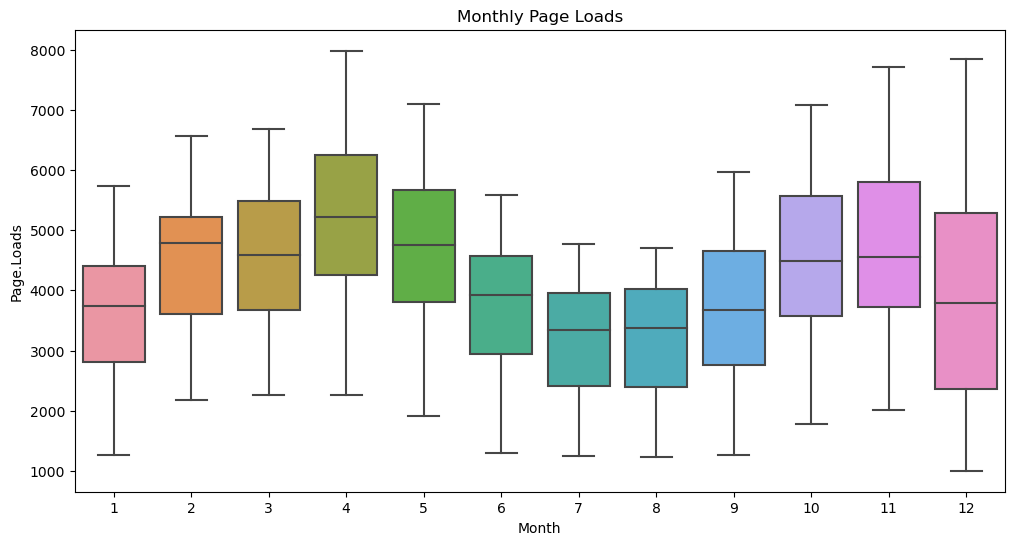

In [243]:

#PLotting for the Monthly Page Loads
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot(data = df2, x = 'Month', y = 'Page.Loads')
ax.set_title('Monthly Page Loads')
plt.show()

### By seeing the plot we can come to the conclusion that in the month of april there was maximum number of page loads

> __Viewing the Plots for the Yearly Page Loads__

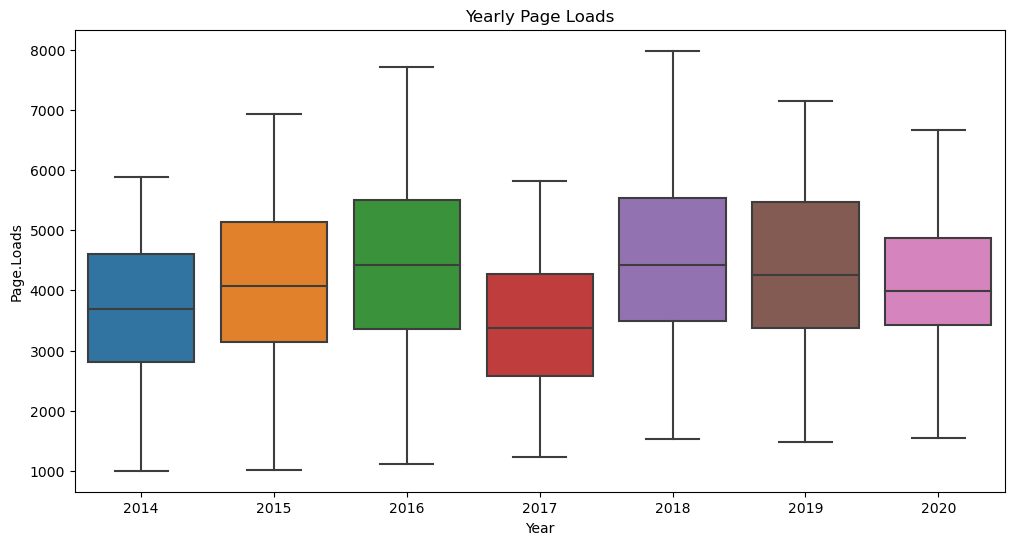

In [244]:

# PLotting for the Yearly Page Loads
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot(data = df2, x = 'Year', y = 'Page.Loads')
ax.set_title('Yearly Page Loads')
plt.show()

### By seeing the plot we can come conclusion that the year 2016 and 2018 were great as there was nice number of page loads in that particular single year

> __Viewing theplot for the Daywise Page Loads__

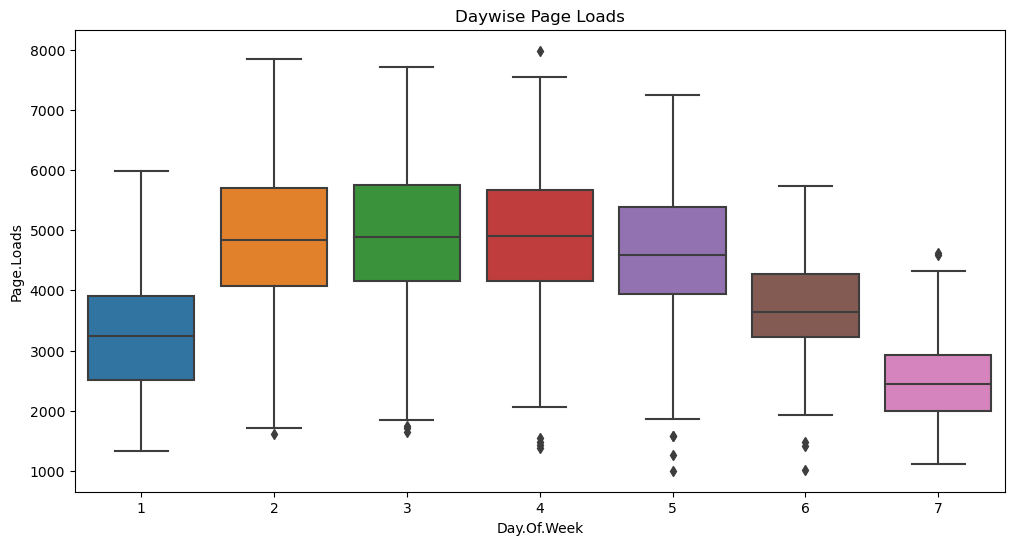

In [245]:

# PLotting for the Daywise Page Loads
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot(data = df2, x = 'Day.Of.Week', y = 'Page.Loads')
ax.set_title('Daywise Page Loads')
plt.show()

> __Extracting the columns whcih are having the numric values in them so that we can see for the outliers and remove them__

In [246]:
# Creating the column list of numeric only 
# that will help in Labeling the Graphs while Viewing the Box Plots and other plots 

numeric_columns_name = df2.select_dtypes(include = ['number']).columns
for index, num_col_name in enumerate(numeric_columns_name):
    print(index, num_col_name)

0 Day.Of.Week
1 Page.Loads
2 Unique.Visits
3 First.Time.Visits
4 Returning.Visits
5 Month
6 Year


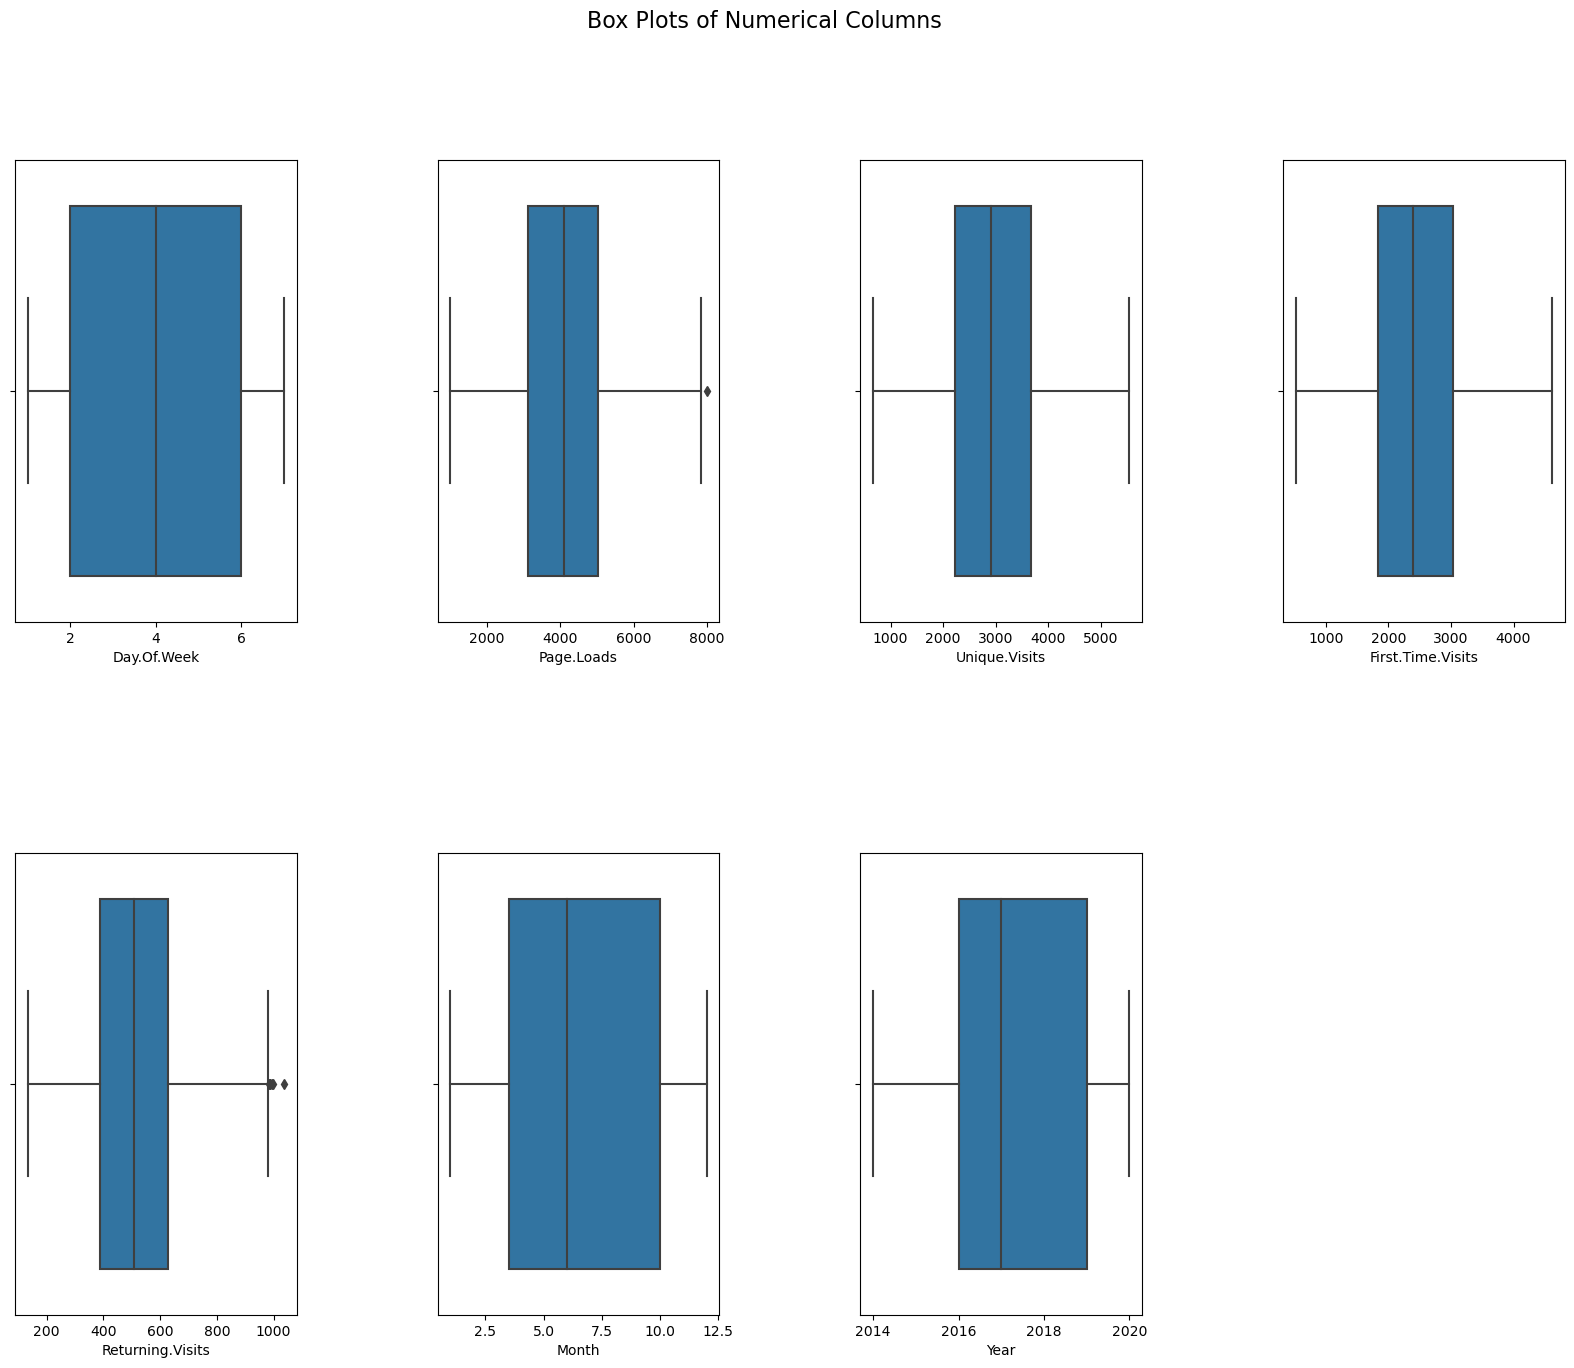

In [247]:
# Determine the number of columns for the subplots grid
n_cols = 4  # Adjust based on how many plots you want in a row
n_rows = (len(numeric_columns_name) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Creating a figure with subplots, arranged in a grid
fig, ax = plt.subplots(n_rows, n_cols, figsize = (20, 15))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)  # Adjust spacing between plots

# Loop through each numerical column to create individual box plots
for i, col in enumerate(numeric_columns_name):
    row = i // n_cols
    col_pos = i % n_cols
    sns.boxplot(x = col, data = df2, ax = ax[row, col_pos])

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(ax.flatten()[j])

# Adding a title to the figure
fig.suptitle('Box Plots of Numerical Columns', fontsize=16)

plt.show()

> __We can see the outliers in the Page.Loads and the Returning vists columsn so we will be removing the outliers in order that the model doesnt learn the outlier pattern__

In [248]:
def remove_outliers_iqr(df, col1, col2):
    """
    Remove outliers from two columns of a DataFrame using the IQR method.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    col1 (str): The name of the first column to remove outliers from.
    col2 (str): The name of the second column to remove outliers from.
    
    Returns:
    pd.DataFrame: The DataFrame with outliers removed for the two specified columns.
    
    """
    # Calculate IQR for the first column
    Q1_col1 = df[col1].quantile(0.25)
    Q3_col1 = df[col1].quantile(0.75)
    IQR_col1 = Q3_col1 - Q1_col1

    # Define bounds for the first column
    lower_bound_col1 = Q1_col1 - 1.5 * IQR_col1
    upper_bound_col1 = Q3_col1 + 1.5 * IQR_col1

    # Calculate IQR for the second column
    Q1_col2 = df[col2].quantile(0.25)
    Q3_col2 = df[col2].quantile(0.75)
    IQR_col2 = Q3_col2 - Q1_col2

    # Define bounds for the second column
    lower_bound_col2 = Q1_col2 - 1.5 * IQR_col2
    upper_bound_col2 = Q3_col2 + 1.5 * IQR_col2

    # Filter out outliers for both columns
    filtered_df = df[(df[col1] >= lower_bound_col1) & (df[col1] <= upper_bound_col1) &
                     (df[col2] >= lower_bound_col2) & (df[col2] <= upper_bound_col2)]
    
    return filtered_df


In [249]:
df2 = remove_outliers_iqr(df2, 'Page.Loads', 'Returning.Visits')

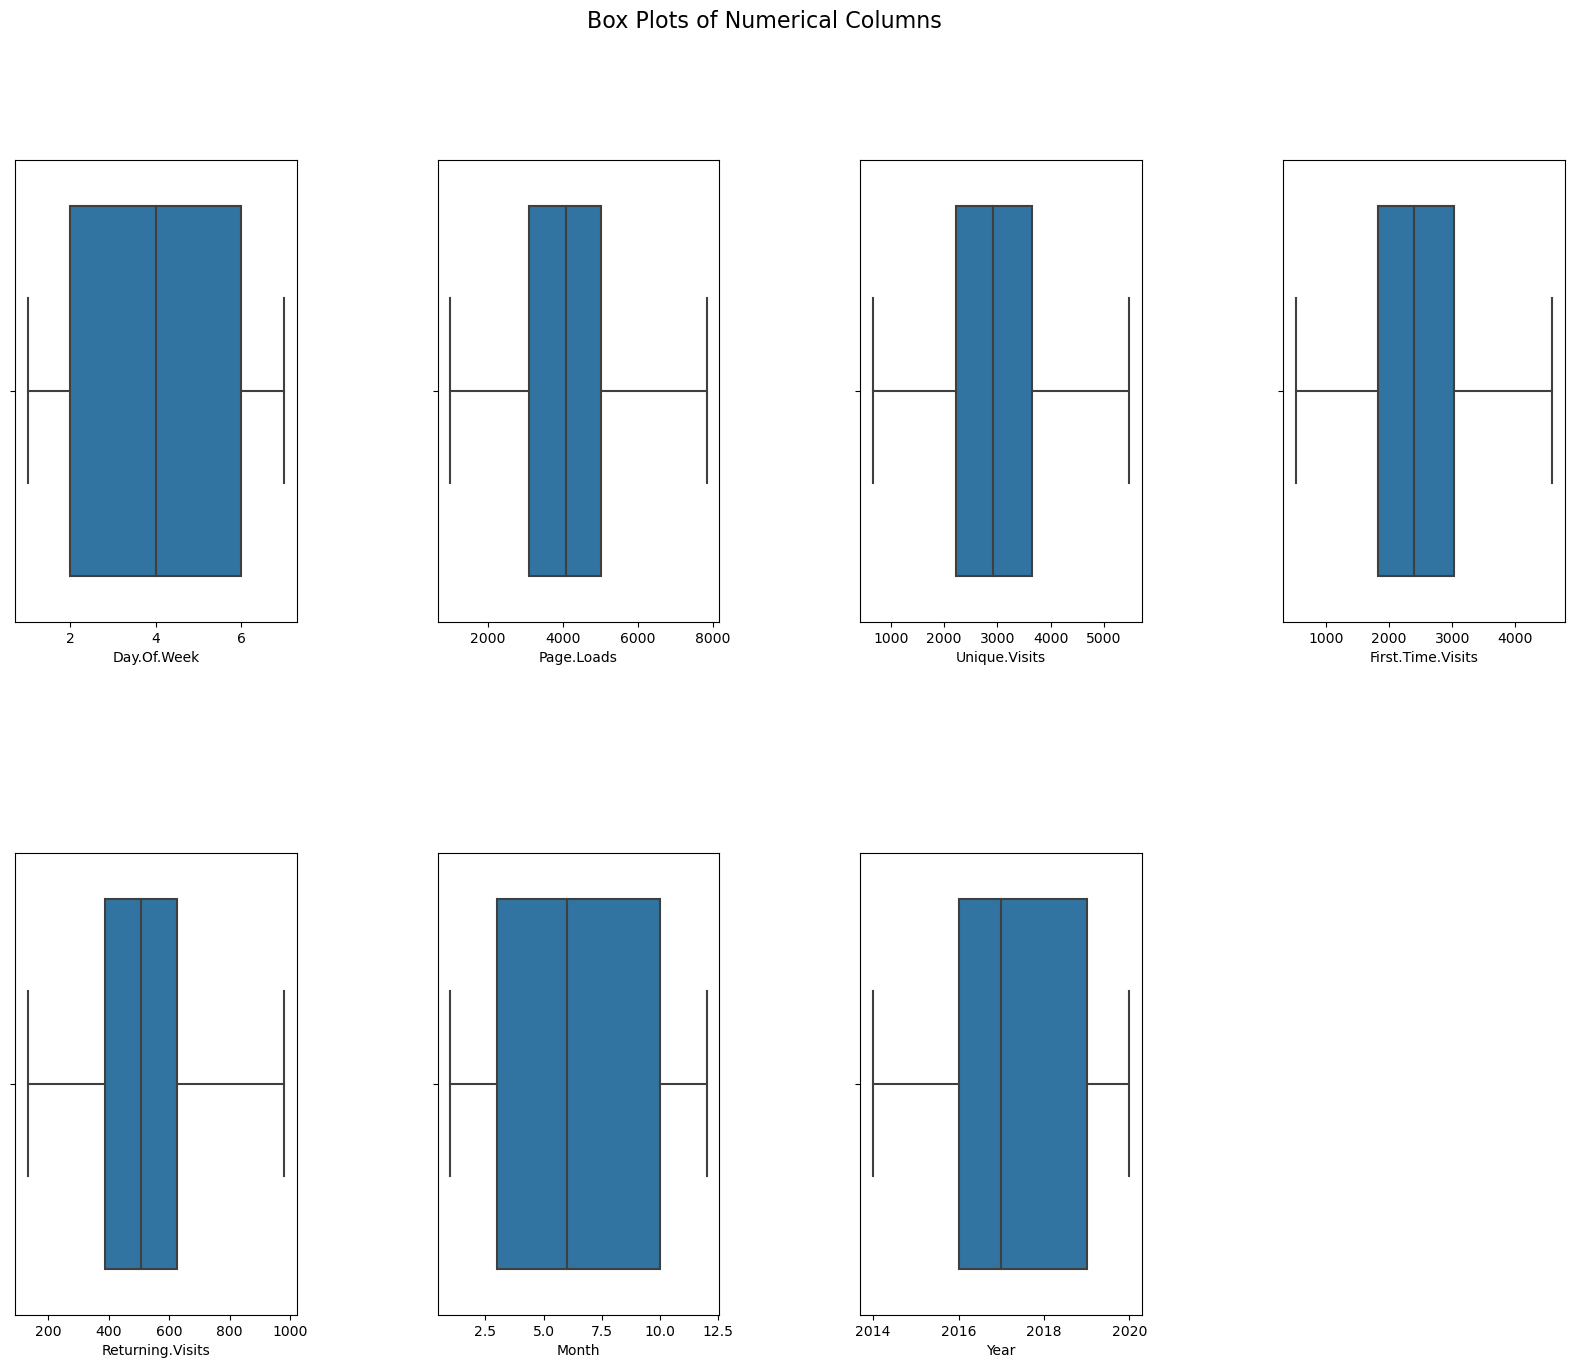

In [250]:
# Determine the number of columns for the subplots grid
n_cols = 4  # Adjust based on how many plots you want in a row
n_rows = (len(numeric_columns_name) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Creating a figure with subplots, arranged in a grid
fig, ax = plt.subplots(n_rows, n_cols, figsize = (20, 15))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)  # Adjust spacing between plots

# Loop through each numerical column to create individual box plots
for i, col in enumerate(numeric_columns_name):
    row = i // n_cols
    col_pos = i % n_cols
    sns.boxplot(x = col, data = df2, ax = ax[row, col_pos])

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(ax.flatten()[j])

# Adding a title to the figure
fig.suptitle('Box Plots of Numerical Columns', fontsize=16)

plt.show()

In [251]:
df2.head()

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year
Date,,,,,,,
2014-09-14,1,2146,1582,1430,152,9,2014
2014-09-15,2,3621,2528,2297,231,9,2014
2014-09-16,3,3698,2630,2352,278,9,2014
2014-09-17,4,3667,2614,2327,287,9,2014
2014-09-18,5,3316,2366,2130,236,9,2014


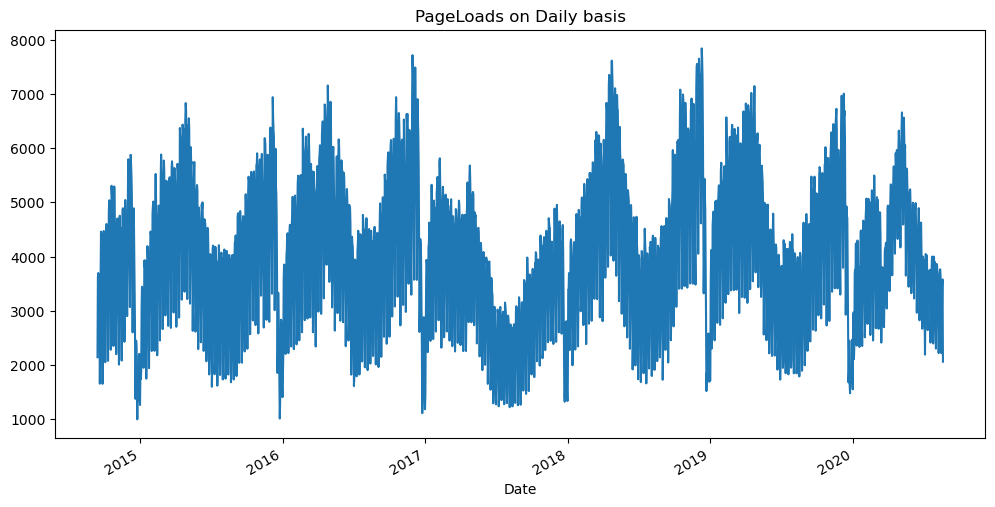

In [252]:
df2['Page.Loads'].plot(figsize = (12, 6), title = 'PageLoads on Daily basis')
plt.show()

> __Initializing the Train and test data__

In [253]:
# Initializing the end dates of train and test dataset
train_dataset_end_date = datetime(2019, 1, 1)
test_dataset_end_date = datetime(2020, 8, 1)

In [254]:
# Setting the train and the test data
train_data = df2[:train_dataset_end_date]
test_data = df2[train_dataset_end_date+ timedelta(days = 1):test_dataset_end_date]

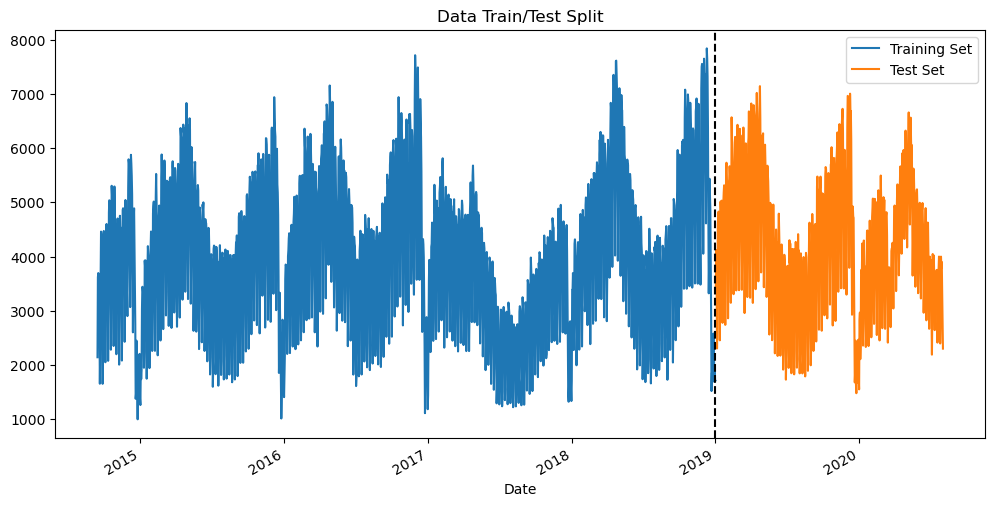

In [255]:
fig, ax = plt.subplots(figsize = (12, 6))
train_data['Page.Loads'].plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test_data['Page.Loads'].plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2019', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [256]:
df2.columns

Index(['Day.Of.Week', 'Page.Loads', 'Unique.Visits', 'First.Time.Visits',
       'Returning.Visits', 'Month', 'Year'],
      dtype='object')

In [257]:

# Creating the Features and Target

FEATURES =['Day.Of.Week', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits', 'Month', 'Year']
TARGET = 'Page.Loads'

In [258]:

# Splitting into X_train, y_train, X_test, y_test 
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

<div style="text-align: center;">
    <h1>XGBoost</h1>
</div>

### Implementing the XGBoost Algorithm

In [91]:
# Making the Parameter List for XGBoost Algo

param_xgb = {'objective':  ['reg:squarederror', 'reg:logistic'],
             'learning_rate' : [0.01, 0.1, 0.2, 0.3, 0.5],
             'n_estimators' : [100, 200, 300, 400, 500, 600],
             }

In [259]:
xgb = XGBRegressor()                                # Making the object of the class

gscvxgb = GridSearchCV(estimator = xgb,             # Loading the parametrs list on to the GrisSearchCV Algo
                       param_grid = param_xgb,
                       scoring = 'r2')

gscvxgb.fit(X_train, y_train)                       # Fitting the model

KeyboardInterrupt: 

In [93]:
# Finding whcih is the best parameters for the XGBoost algo

gscvxgb.best_params_

{'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'reg:squarederror'}

In [260]:
xgb1 = XGBRegressor(n_estimators = 100, 
                    early_stopping_rounds = 50,
                    learning_rate = 0.1,
                    objective = 'reg:squarederror')

xgb1.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:1241.55394	validation_1-rmse:1133.55526
[68]	validation_0-rmse:65.91941	validation_1-rmse:388.26715


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Getting the Important features and seeing which is the feature that the model uses the most

In [261]:
dataframe = pd.DataFrame(data = xgb1.feature_importances_, 
            index = xgb1.feature_names_in_,
            columns = ['Importance'])

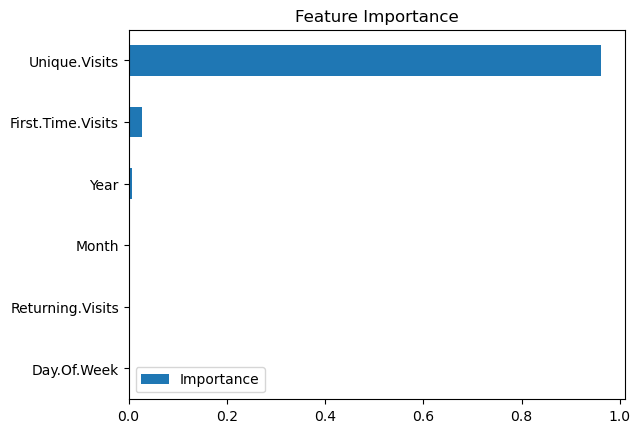

In [262]:
dataframe.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

### Predicting on the Test data of the XGBoost Algorithm

In [263]:
test_data['Prediction_XGBoost'] = xgb1.predict(X_test)

In [264]:
df2 = df2.merge(test_data[['Prediction_XGBoost']], how = 'left', left_index = True, right_index = True)

In [265]:
df2.head()

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year,Prediction_XGBoost
Date,,,,,,,,
2014-09-14,1,2146,1582,1430,152,9,2014,NaN
2014-09-15,2,3621,2528,2297,231,9,2014,NaN
2014-09-16,3,3698,2630,2352,278,9,2014,NaN
2014-09-17,4,3667,2614,2327,287,9,2014,NaN
2014-09-18,5,3316,2366,2130,236,9,2014,NaN


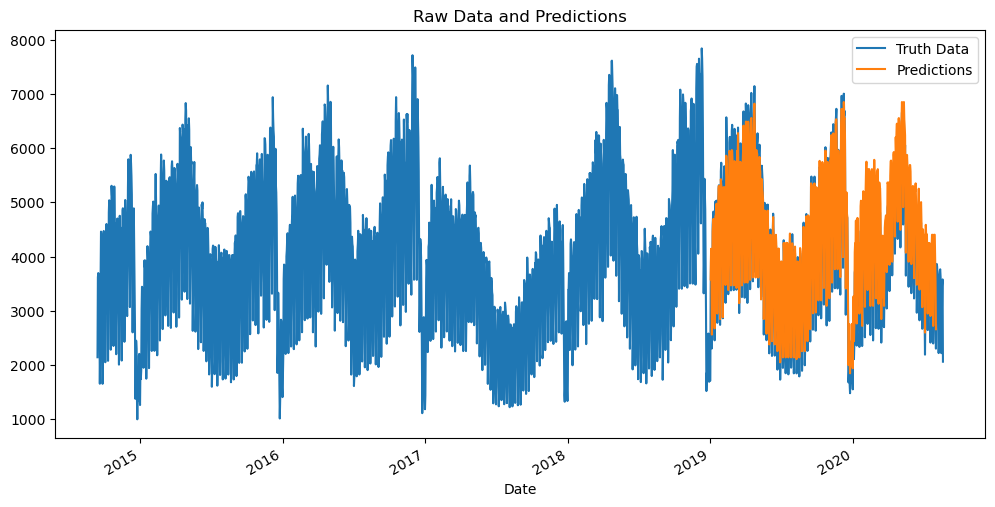

In [267]:
ax = df2[['Page.Loads']].plot(figsize = (12, 6))
df2['Prediction_XGBoost'].plot(ax = ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

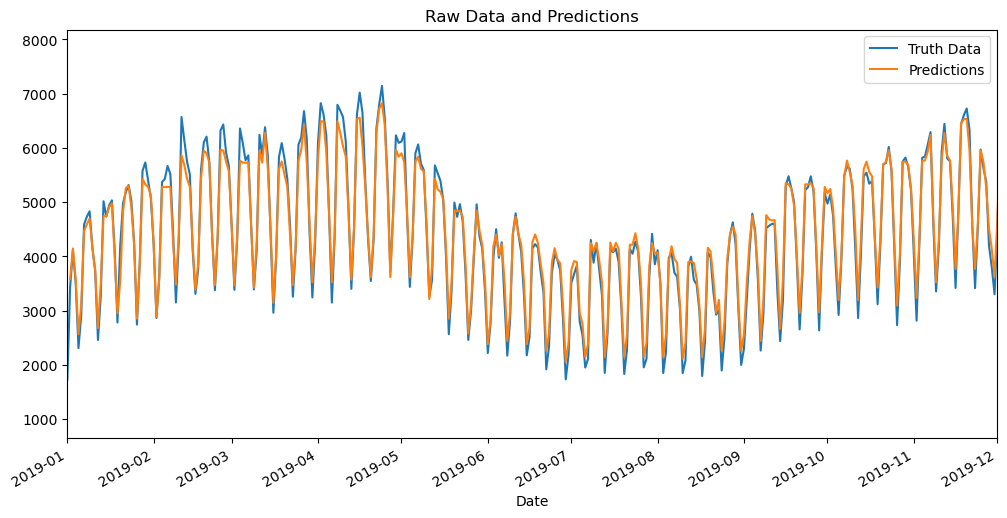

In [269]:
ax = df2[['Page.Loads']].plot(xlim = ['2019-01-01', '2019-12-01'], figsize = (12, 6))
df2['Prediction_XGBoost'].plot(ax = ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

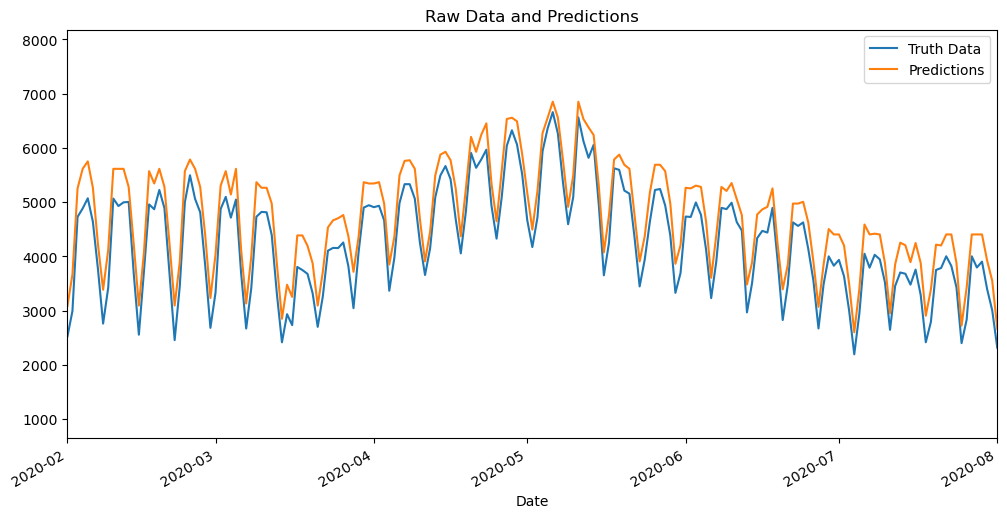

In [271]:
ax = df2[['Page.Loads']].plot(xlim = ['2020-02-01', '2020-08-01'], figsize = (12, 6))
df2['Prediction_XGBoost'].plot(ax = ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [303]:
XGBoost_RMSE = root_mean_squared_error(test_data['Page.Loads'], test_data['Prediction_XGBoost'])

In [273]:
# Calculate the Error
np.abs(test_data['Page.Loads'] - test_data['Prediction_XGBoost'])

Date
2019-01-02    151.958008
2019-01-03     27.467285
2019-01-04     78.958008
2019-01-05    255.540527
2019-01-06    188.042236
                 ...    
2020-07-28    609.215820
2020-07-29    501.215820
2020-07-30    525.944336
2020-07-31    545.519043
2020-08-01    357.364746
Length: 578, dtype: float64

In [274]:

# Saving the model
xgb1.save_model('xgb_website_forecasting_model.json')

<div style="text-align: center;">
    <h1>Random Forest</h1>
</div>

In [89]:
# Making the Parameter List for Random Forest which will be passed to the GridSearchCV 

param_rf = {'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
            'n_estimators' : [10, 30, 50, 100, 200, 250, 300]
           }

In [90]:
# Making the object of the Random forest setting up the GridSearchCV and fitting the model

rf = RandomForestRegressor()                           # Making the object of the class Random Forest

gscvrf = GridSearchCV(estimator = rf,                   # Making the object of GridSearchCV and Adding the parameters
                      param_grid = param_rf,
                      scoring = 'r2')

gscvrf.fit(X_train, y_train)                            # Fitting the Model

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'n_estimators': [10, 30, 50, 100, 200, 250, 300]},
             scoring='r2')

In [111]:
# Finding which is the best parameter

gscvrf.best_params_

{'criterion': 'friedman_mse', 'n_estimators': 250}

In [275]:
rf1 = RandomForestRegressor(n_estimators = 250,
                            criterion = 'friedman_mse')

rf1.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', n_estimators=250)

### Getting the Important features and seeing which is the feature that the model uses the most

In [276]:
dataframe = pd.DataFrame(data = rf1.feature_importances_, 
            index = xgb1.feature_names_in_,
            columns = ['Importance'])

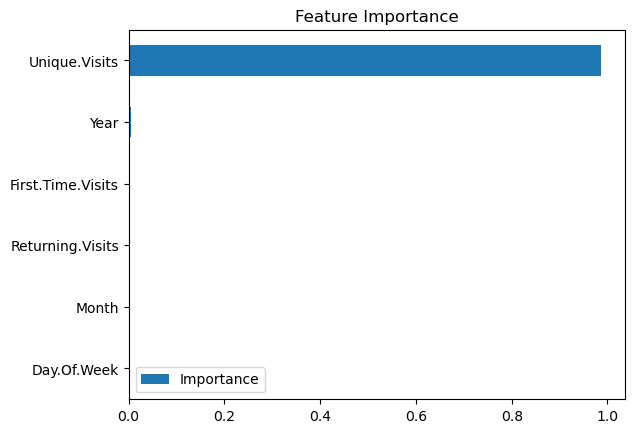

In [277]:
dataframe.sort_values('Importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

### Predicting on the data for the Random Forest Algorithm

In [278]:
test_data['Prediction_RandonForest'] = rf1.predict(X_test)

In [279]:
df2 = df2.merge(test_data[['Prediction_RandonForest']], how = 'left', left_index = True, right_index = True)

In [280]:
df2.head()

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year,Prediction_XGBoost,Prediction_RandonForest
Date,,,,,,,,,
2014-09-14,1,2146,1582,1430,152,9,2014,NaN,NaN
2014-09-15,2,3621,2528,2297,231,9,2014,NaN,NaN
2014-09-16,3,3698,2630,2352,278,9,2014,NaN,NaN
2014-09-17,4,3667,2614,2327,287,9,2014,NaN,NaN
2014-09-18,5,3316,2366,2130,236,9,2014,NaN,NaN


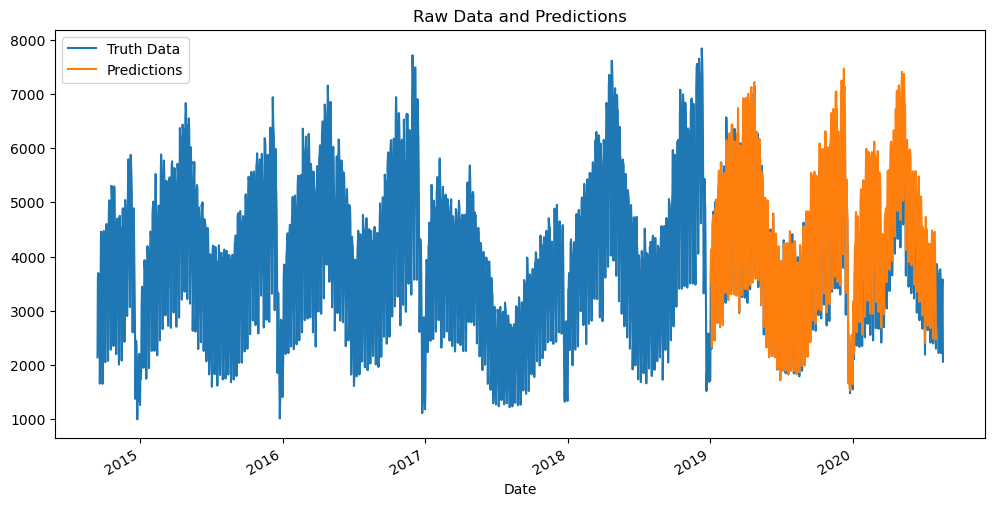

In [281]:
ax = df2[['Page.Loads']].plot(figsize = (12, 6))
df2['Prediction_RandonForest'].plot(ax = ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

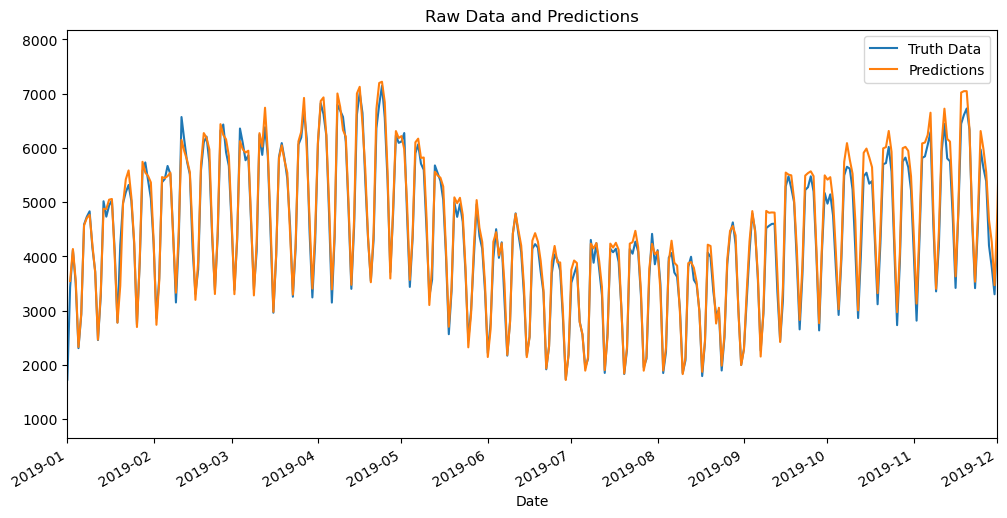

In [282]:
ax = df2[['Page.Loads']].plot(xlim = ['2019-01-01', '2019-12-01'], figsize = (12, 6))
df2['Prediction_RandonForest'].plot(ax = ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

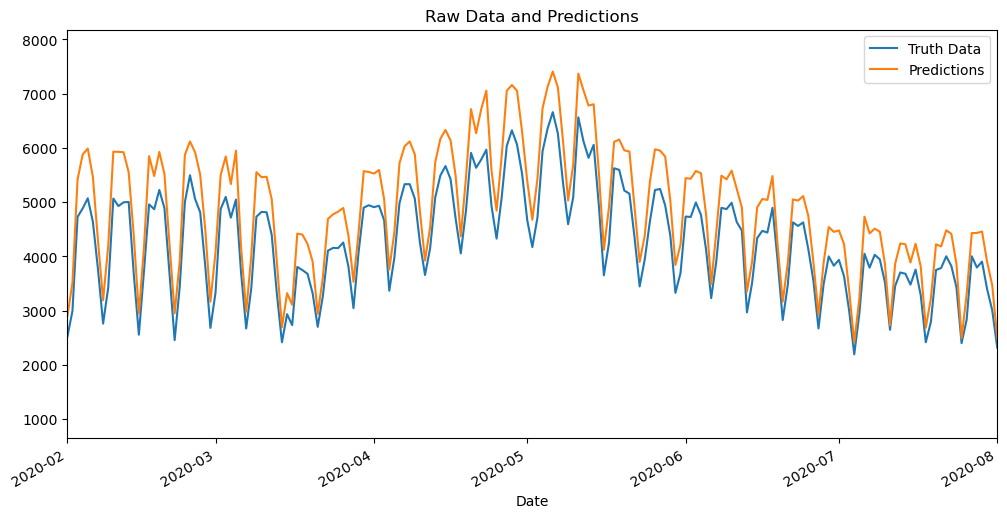

In [283]:
ax = df2[['Page.Loads']].plot(xlim = ['2020-02-01', '2020-08-01'], figsize = (12, 6))
df2['Prediction_RandonForest'].plot(ax = ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [304]:
RandomForest_RMSE = root_mean_squared_error(test_data['Page.Loads'], test_data['Prediction_RandonForest'])

In [285]:
# Calculate the Error
np.abs(test_data['Page.Loads'] - test_data['Prediction_XGBoost'])

Date
2019-01-02    151.958008
2019-01-03     27.467285
2019-01-04     78.958008
2019-01-05    255.540527
2019-01-06    188.042236
                 ...    
2020-07-28    609.215820
2020-07-29    501.215820
2020-07-30    525.944336
2020-07-31    545.519043
2020-08-01    357.364746
Length: 578, dtype: float64

In [305]:
# Comparision of the rmse scores of XGBoost and Random Forest

final_results = {'Algorithm' : ['XGBoost', 'Random Forest'],
                 'RMSE' : [XGBoost_RMSE, RandomForest_RMSE]
                }

final_results = pd.DataFrame(final_results)

In [306]:
final_results.head()

,Algorithm,RMSE
0,XGBoost,332.715649
1,Random Forest,400.583258


<function matplotlib.pyplot.show(close=None, block=None)>

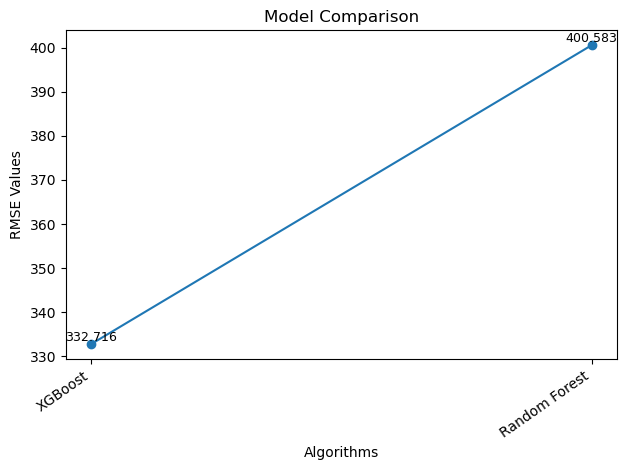

In [310]:
# plotting the results

# Add labels to the marker points
for i, value in enumerate(final_results['RMSE']):
    plt.text(final_results['Algorithm'][i], value + (0.015),  # Slightly above the marker
             f'{value:.3f}', ha='center', va='bottom', fontsize=9, color='black')

plt.plot(final_results['Algorithm'], final_results['RMSE'], marker = 'o')
plt.xlabel('Algorithms')
plt.ylabel('RMSE Values')
plt.title('Model Comparison')
plt.xticks(rotation = 35, ha = 'right')
plt.tight_layout()
plt.show

### Thus through this we can say that since RMSE of XGBoost is lower than the Randomforest 
### i.e The XGBoost is able to capture more data rather than the Random Forest

<div style="text-align: center;">
    <h1>Predicting the future for the next 1 year</h1>
</div>

In [286]:
df2.index.max()

Timestamp('2020-08-19 00:00:00')

> __Creating a future dates dataset__

In [287]:
future = pd.date_range('2020-08-19', '2021-08-01', freq = 'D')
future_df2 = pd.DataFrame(index = future)

In [288]:
future_df2['isFuture'] = True
df2['isFuture'] = False

In [289]:
df2_and_future = pd.concat([df2, future_df2])

In [290]:
df2_and_future['Month'] = df2_and_future.index.month

In [291]:
df2_and_future['Year'] = df2_and_future.index.year

> __Generating random samples to fill in the data__

In [292]:

# Generate random samples from the existing non-NaN values
random_values = np.random.choice(df2_and_future['Unique.Visits'].dropna(), size=df2_and_future['Unique.Visits'].isna().sum())

# Assign the random values to NaN positions using the DataFrame index
df2_and_future.loc[df2_and_future['Unique.Visits'].isna(), 'Unique.Visits'] = random_values


In [293]:

# Generate random samples from the existing non-NaN values
random_values = np.random.choice(df2_and_future['First.Time.Visits'].dropna(), size=df2_and_future['First.Time.Visits'].isna().sum())

# Assign the random values to NaN positions using the DataFrame index
df2_and_future.loc[df2_and_future['First.Time.Visits'].isna(), 'First.Time.Visits'] = random_values


In [294]:

# Generate random samples from the existing non-NaN values
random_values = np.random.choice(df2_and_future['Returning.Visits'].dropna(), size=df2_and_future['Returning.Visits'].isna().sum())

# Assign the random values to NaN positions using the DataFrame index
df2_and_future.loc[df2_and_future['Returning.Visits'].isna(), 'Returning.Visits'] = random_values


In [295]:
Only_future_data = df2_and_future.query('isFuture').copy()

In [296]:
Only_future_data

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year,Prediction_XGBoost,Prediction_RandonForest,isFuture
2020-08-19,NaN,NaN,3493.0,1616.0,303.0,8,2020,NaN,NaN,True
2020-08-20,NaN,NaN,3260.0,2923.0,484.0,8,2020,NaN,NaN,True
2020-08-21,NaN,NaN,3938.0,2306.0,897.0,8,2020,NaN,NaN,True
2020-08-22,NaN,NaN,3868.0,3113.0,573.0,8,2020,NaN,NaN,True
2020-08-23,NaN,NaN,3457.0,3684.0,558.0,8,2020,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...
2021-07-28,NaN,NaN,4583.0,2158.0,321.0,7,2021,NaN,NaN,True
2021-07-29,NaN,NaN,1658.0,3266.0,456.0,7,2021,NaN,NaN,True
2021-07-30,NaN,NaN,1809.0,2103.0,515.0,7,2021,NaN,NaN,True
2021-07-31,NaN,NaN,2976.0,3572.0,281.0,7,2021,NaN,NaN,True


> __Predicting the future firecast using the XGBoost algorithm__

In [297]:
# Predicting from XGBoost 
Only_future_data['Future_pred_XGBoost'] = xgb1.predict(Only_future_data[FEATURES])

In [298]:
Only_future_data

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year,Prediction_XGBoost,Prediction_RandonForest,isFuture,Future_pred_XGBoost
2020-08-19,NaN,NaN,3493.0,1616.0,303.0,8,2020,NaN,NaN,True,4906.464844
2020-08-20,NaN,NaN,3260.0,2923.0,484.0,8,2020,NaN,NaN,True,4643.068848
2020-08-21,NaN,NaN,3938.0,2306.0,897.0,8,2020,NaN,NaN,True,5471.914062
2020-08-22,NaN,NaN,3868.0,3113.0,573.0,8,2020,NaN,NaN,True,5304.450684
2020-08-23,NaN,NaN,3457.0,3684.0,558.0,8,2020,NaN,NaN,True,5019.491699
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-28,NaN,NaN,4583.0,2158.0,321.0,7,2021,NaN,NaN,True,6035.269531
2021-07-29,NaN,NaN,1658.0,3266.0,456.0,7,2021,NaN,NaN,True,2660.784668
2021-07-30,NaN,NaN,1809.0,2103.0,515.0,7,2021,NaN,NaN,True,2862.482666
2021-07-31,NaN,NaN,2976.0,3572.0,281.0,7,2021,NaN,NaN,True,4558.903320


<AxesSubplot:title={'center':'Future Predictions from XGBoost'}>

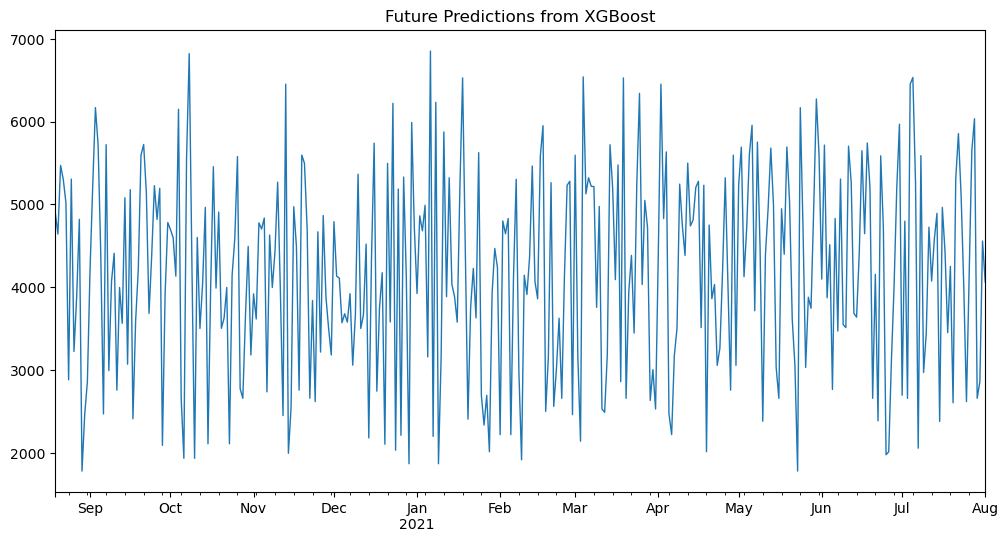

In [299]:
Only_future_data['Future_pred_XGBoost'].plot(figsize = (12, 6), ms = 1, lw = 1, 
                                             title = 'Future Predictions from XGBoost')

> __Predicting the future forecast using Random Forest Alogorithm__

In [300]:
# Predicting from Random Forest 
Only_future_data['Future_pred_Random_Forest'] = rf1.predict(Only_future_data[FEATURES])

In [301]:
Only_future_data

,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Month,Year,Prediction_XGBoost,Prediction_RandonForest,isFuture,Future_pred_XGBoost,Future_pred_Random_Forest
2020-08-19,NaN,NaN,3493.0,1616.0,303.0,8,2020,NaN,NaN,True,4906.464844,5001.264
2020-08-20,NaN,NaN,3260.0,2923.0,484.0,8,2020,NaN,NaN,True,4643.068848,4784.460
2020-08-21,NaN,NaN,3938.0,2306.0,897.0,8,2020,NaN,NaN,True,5471.914062,5749.288
2020-08-22,NaN,NaN,3868.0,3113.0,573.0,8,2020,NaN,NaN,True,5304.450684,5542.724
2020-08-23,NaN,NaN,3457.0,3684.0,558.0,8,2020,NaN,NaN,True,5019.491699,5073.632
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-28,NaN,NaN,4583.0,2158.0,321.0,7,2021,NaN,NaN,True,6035.269531,6664.404
2021-07-29,NaN,NaN,1658.0,3266.0,456.0,7,2021,NaN,NaN,True,2660.784668,2408.920
2021-07-30,NaN,NaN,1809.0,2103.0,515.0,7,2021,NaN,NaN,True,2862.482666,2618.332
2021-07-31,NaN,NaN,2976.0,3572.0,281.0,7,2021,NaN,NaN,True,4558.903320,4445.156


<AxesSubplot:title={'center':'Future Predictions from Random Forest'}>

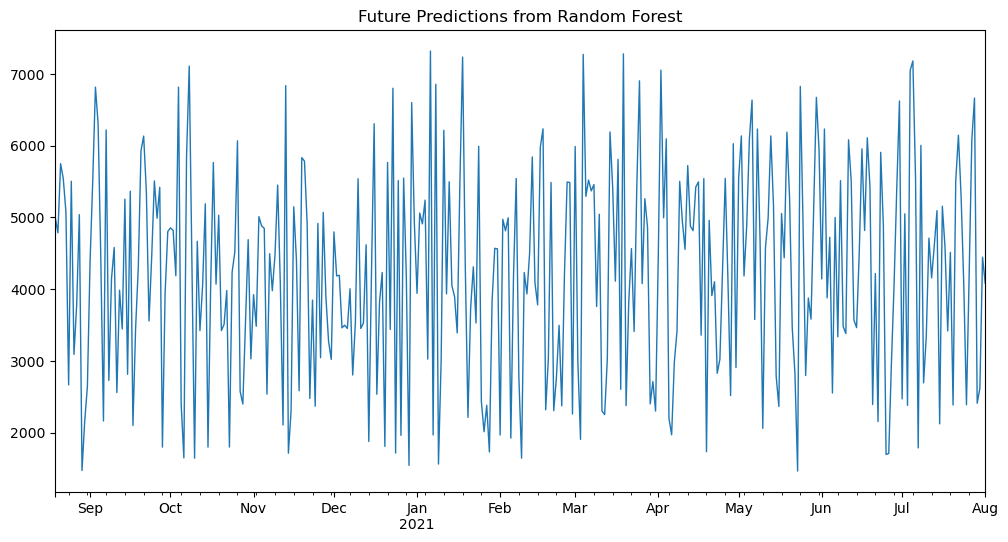

In [302]:
Only_future_data['Future_pred_Random_Forest'].plot(figsize = (12, 6), ms = 1, lw = 1, 
                                                   title = 'Future Predictions from Random Forest')

### The "Final_Website_Traffic_ForeCasting" script presents a comprehensive approach to forecasting website traffic through a combination of traditional time series analysis and modern machine learning techniques. Key aspects include:

> Data Preparation: The code effectively preprocesses raw data by converting date formats, cleaning numeric columns, and addressing outliers, ensuring the dataset is suitable for analysis.

> Exploratory Data Analysis (EDA): Visualization techniques are employed to understand data distributions, detect outliers, and assess stationarity. Functions for generating ACF and PACF plots further aid in understanding the time series characteristics.

> Modeling Approaches: The script implements both SARIMA for time series forecasting and machine learning algorithms (XGBoost and Random Forest) for predicting website traffic. Model evaluation is conducted using metrics such as AIC, BIC, and RMSE, allowing for the selection of the best-performing models.

> Future Predictions: The models are utilized to generate predictions for future traffic, filling missing values with random samples from existing data, and the results are visualized for comparison against actual values.

> Robustness: The integration of statistical methods and machine learning creates a robust framework for forecasting, enabling better understanding and planning for website traffic.

> __Overall, the script is a valuable resource for practitioners looking to analyze and predict website traffic, combining statistical rigor with machine learning innovations. Potential improvements include enhanced documentation, modularization, and the exploration of more complex models for further accuracy.__